In [1]:
import pandas as pd
import glob

def combine_excel_files_vertically(directory_path):
    # Step 1: Get a list of 
    # all Excel files in the specified directory
    excel_files = glob.glob(f'{directory_path}/*.xlsx')
    
    # Step 2: Initialize an empty list to store DataFrames
    dfs = []

    # Step 3: Loop through each 
    #Excel file and append its data to the list
    for file in excel_files:
        df = pd.read_excel(file)
        dfs.append(df)

    # Step 4: Use pandas.concat to combine 
    # all DataFrames in the list vertically
    combined_df = pd.concat(dfs, axis=0, ignore_index=False)

    return combined_df

# Example usage:
directory_path = '/home/majd/Desktop/Arbeit/Project'  
# Replace with the actual path
result_df = combine_excel_files_vertically(directory_path)



In [2]:
result_df.columns

Index(['Line', 'File', 'TrnID', 'Time', 'Time (with seconds)', 'HP', 'PAL',
       'Min', 'ON', 'OpThreshold', 'ClksThisMin', 'SpClass', 'Qn', 'ICIgood',
       'tWUTrisk', 'Marked', 'Start', 'Time (s)', 'Time (m)', 'Time (h)',
       'Time (h) *5', 'NofClx', 'nActualClx', 'medianKHz', 'avEndF',
       'nRisingIPIs', 'avSPL', 'avPkAt', 'avBWx8', 'TrDur_us', 'AvPRF',
       'nICIrising', 'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
       'ClkNofMaxICI', 'NofClstrs', 'avClstrNx8', 'avclF0', 'avclF1',
       'avPkIPI', 'BeforeIPIratio', 'PreIPIratio', 'Post1IPIratio',
       'Post2IPIratio', 'EndIPIratio', 'EncSpN', 'Time (s).1'],
      dtype='object')

In [3]:
columns_names = ['NofClx', 'nActualClx', 'medianKHz', 'avEndF',
       'nRisingIPIs', 'avSPL', 'avPkAt', 'avBWx8', 'TrDur_us', 
       'AvPRF',
       'nICIrising', 'MinICI_us', 'midpointICI', 'MaxICI_us', 
       'ClkNofMinICI',
       'ClkNofMaxICI', 'NofClstrs', 'avClstrNx8', 'avclF0', 
       'avclF1',
       'avPkIPI', 'BeforeIPIratio', 'PreIPIratio', 
       'Post1IPIratio',
       'Post2IPIratio', 'EndIPIratio']


In [4]:
def build_input_data(result_df, columns_names):
    X = result_df[columns_names]
    return X

In [5]:
def y_cleaning(y):
    y = result_df[['HP']]
    y = y.fillna(0)
    y = y.replace('?',1)
    return y

In [6]:
# X are the columns
# y is the label 
# 1 HP for Harbour porpoise 
X = build_input_data(result_df, columns_names)
y = y_cleaning(result_df[['HP']])

In [12]:
from sklearn.model_selection import train_test_split

def traintestsplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                    test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [13]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = traintestsplit(X, y)

In [14]:
y_train_transform = y_train.ravel()
y_test_transform = y_test.ravel()

In [15]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized



In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

def preprocss_data(X_train, X_test, y_train_transform, 
                   y_test_transform):
    scaler = StandardScaler()
    minimax = MinMaxScaler()
    robustscaler = RobustScaler()
    smote = SMOTE(random_state=42)
    X_train = minimax.fit_transform(X_train)
    X_test = minimax.transform(X_test)
    X_train = robustscaler.fit_transform(X_train)
    X_test = robustscaler.transform(X_test)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train_resampled, y_train_resampled = smote.fit_resample(
        X_train, y_train_transform)
    X_test_resampled, y_test_resampled = smote.fit_resample(
        X_test, y_test_transform)

    return X_train_resampled, X_test_resampled, \
y_train_resampled, y_test_resampled


    
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = \
preprocss_data(X_train, X_test, 
                    y_train_transform, y_test_transform)

In [24]:
# X_train_normalized, X_test_normalized = normalize_data(X_train, X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier
def train_ForestClassifier(X_train, y_train,n_trees):
    clf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    clf.fit(X_train, y_train)
    return clf

In [26]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)


(265156, 26)
(265156,)


In [28]:
# 1 minute for 50 trees                
randomforest = train_ForestClassifier(X_train_resampled ,
                                       y_train_resampled, n_trees=100)

In [29]:
import joblib
joblib.dump(randomforest, 'randomforest_model.joblib')

['randomforest_model.joblib']

In [30]:
predictions = randomforest.predict(X_test_resampled)

Accuracy: 0.9703328509406657


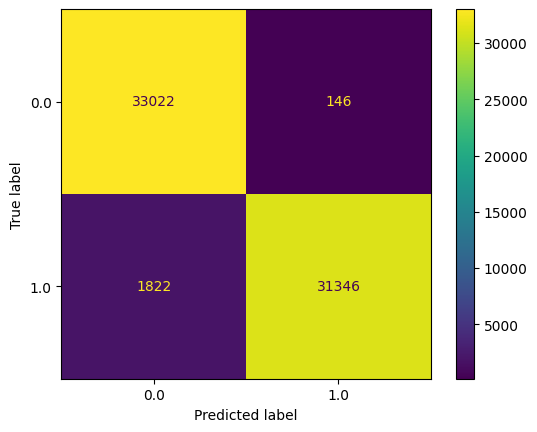

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     33168
         1.0       1.00      0.95      0.97     33168

    accuracy                           0.97     66336
   macro avg       0.97      0.97      0.97     66336
weighted avg       0.97      0.97      0.97     66336

Confusion Matrix:
 [[33022   146]
 [ 1822 31346]]


In [32]:
from sklearn.metrics import confusion_matrix, \
ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import \
classification_report, confusion_matrix
from sklearn.metrics import \
accuracy_score, classification_report, confusion_matrix
# Evaluate on the test set
accuracy = accuracy_score(y_test_resampled, predictions)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_resampled, predictions,
                      labels=randomforest.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=randomforest.classes_)
disp.plot()
plt.show()
print("Classification Report:\n", 
      classification_report(y_test_resampled, predictions))
print("Confusion Matrix:\n", cm)


In [33]:

loaded_model = joblib.load('randomforest_model.joblib')

In [34]:
predictions_new = loaded_model.predict(X_test_resampled)

In [35]:
predictions_new.shape

(66336,)

In [36]:
import numpy as np

# Assuming predictions_new is a NumPy array
unique_values, counts = np.unique(predictions_new, return_counts=True)

# Display the counts for each unique value
for value, count in zip(unique_values, counts):
    print(f"Value {value}: Count {count}")


Value 0.0: Count 34844
Value 1.0: Count 31492


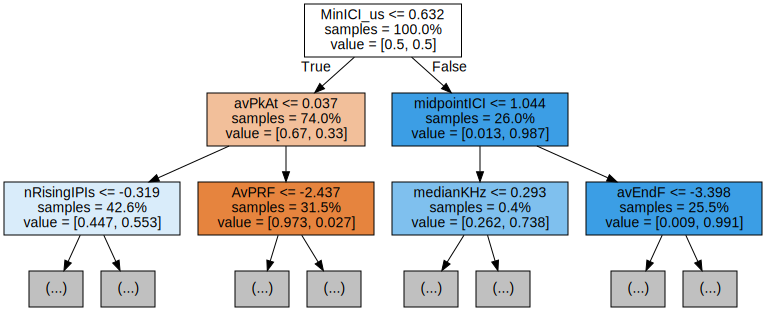

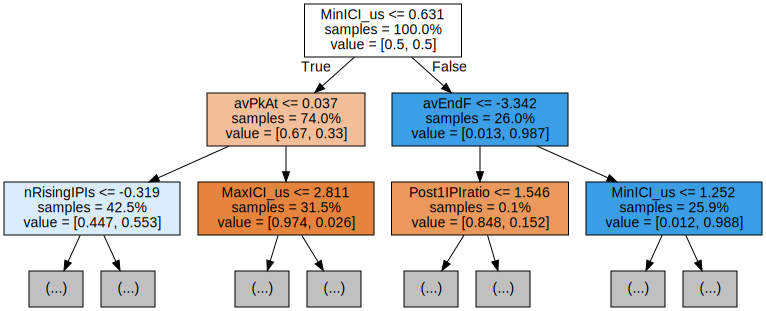

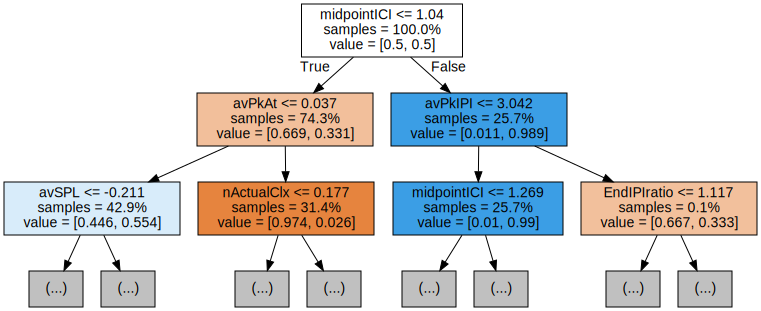

In [38]:
# Export the first three decision trees from the forest
from sklearn.tree import export_graphviz
import graphviz
for i in range(3):
    tree = randomforest.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [50]:
import xgboost as xgb


In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_XGBoost(X_train, y_train):
    clf = xgb.XGBClassifier(n_estimators=800, random_state=42)
    clf.fit(X_train, y_train)
    return clf



In [53]:
# Train XGBoost classifier
xgboost_model = train_XGBoost(X_train_resampled, y_train_resampled)
import joblib
joblib.dump(xgboost_model, 'xgboost_model.joblib')


['xgboost_model.joblib']

In [54]:
# Load the XGBoost model
loaded_xgboost_model = joblib.load('xgboost_model.joblib')

# Make predictions
xgboost_predictions = loaded_xgboost_model.predict(X_test_resampled)


In [55]:
# Evaluate on the test set
xgboost_accuracy = accuracy_score(y_test_resampled, xgboost_predictions)
print("XGBoost Accuracy:", xgboost_accuracy)

xgboost_cm = confusion_matrix(y_test_resampled, xgboost_predictions, labels=loaded_xgboost_model.classes_)
print("XGBoost Confusion Matrix:\n", xgboost_cm)

print("XGBoost Classification Report:\n", classification_report(y_test_resampled, xgboost_predictions))


XGBoost Accuracy: 0.9900657260009648
XGBoost Confusion Matrix:
 [[33056   112]
 [  547 32621]]
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     33168
         1.0       1.00      0.98      0.99     33168

    accuracy                           0.99     66336
   macro avg       0.99      0.99      0.99     66336
weighted avg       0.99      0.99      0.99     66336

